# LDA线性判别分析算法
线性判别分析（linear discriminant analysis, LDA）一种常用的数据降维方法，目的是在保持分类的前体下把数据投影至低维空间以降低计算复杂度。

LDA和PCA都是利用线性变换对数据进行降维的机器学习技术。之前也对主成分分析（PCA）原理进行了总结。PCA是一种无监督的降维技术，无视数据的分类信息挖掘数据中的模式，投影后方差最大的方向即为主成分。LDA是一种有监督的降维技术，对数据进行模式分类。如图所示，LDA要求类间的方差最大，而类内的方差最小，以保证投影后同一分类数据集中，不同分类间数据距离尽可能大。

## LDA算法的优缺点
- 优点：
  - 在降维过程中可以使用类别的先验知识经验，而像PCA这样的无监督学习则无法使用类别先验知识。
  - LDA在样本分类信息依赖均值而不是方差的时候，比PCA之类的算法较优。
- 缺点：
  - LDA不适合对非高斯分布样本进行降维，PCA也有这个问题
  - LDA在样本分类信息依赖方差而不是均值的时候，降维效果不好

In [19]:
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as snn
from collections import Counter
from imblearn.over_sampling import SMOTE  # 过采样算法
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,classification_report
from sklearn import preprocessing
minmax  = preprocessing.MinMaxScaler()

In [21]:
class myLDA:  # 二分类LDA算法 python实现
    def fit (self,data): # data是numpy类型的数据，要求数据是二分类的
        # 判断data数据集是否是二分类的
        temp_x =  data[:,:-1] #获取数据集中的特征数据
        temp_y =  data[:,-1] #获取数据集中的标签数据
        self.labels = Counter(temp_y)  ##统计temp_y中元素以及对应元素出现的次数，返回一个字典
        if len(self.labels.keys()) !=2:
            raise ValueError("该数据集不是二分类问题，请重新输入数据集！")
        else:
            x1 = [] # 存储第一类标签的数据x
            x2 = [] # 存储第二类标签的数据x
            # 下面判断 数据集中的两种标签比例是否为1:1
            label_dic = list(self.labels.keys())
            if label_dic[0] ==label_dic[1]: #说明两类标签比例为1:1
                for x,y in zip(temp_x,temp_y):
                    if y == label_dic[0]:
                        x1.append(x)
                    else:
                        x2.append(x)
                x1 = np.array(x1) #将第一类标签的数据转化为数组类型的数据
                x2 = np.array(x2) #将第二类标签的数据转化为数组类型的数据
            else:  # 如果样本类别不平衡
                #SMOTE过采样
                smo = SMOTE(random_state=42)
                x_smo, y_smo = smo.fit_resample(temp_x, temp_y)
                for x,y in zip(x_smo,y_smo):
                    if y ==label_dic[0]:
                        x1.append(x)
                    else:
                        x2.append(x)
                x1 = np.array(x1)
                x2 = np.array(x2)
            ## 利用LDA算法求解最优的 w

            mu_1 = np.mean(x1,axis = 0) # 对第一类标签的数据中每一个特征求均值
            mu_2 = np.mean(x2,axis = 0) # 对第二类标签的数据中每一个特征求均值
            x1_shape = x1.shape
            x2_shape = x2.shape
            sigma1 = np.zeros((x1_shape[1],x1_shape[1]))   #初始化第一类样本的协方差矩阵
            sigma2 = np.zeros((x2_shape[1],x2_shape[1]))   #初始化第二类样本的协方差矩阵

            for i in range(x1_shape[0]): #遍历每一个样本
                temp_x1 = x1[i,:]-mu_1 #计算第一类中的第i个样本与均值的差
                temp_x2 = x2[i,:]-mu_2 #计算第二类中的第i个样本与均值的差
                temp_sigma1 = np.dot(temp_x1.reshape([-1,1]),[temp_x1]) #计算 (xi-mu)(xi-mu)T
                temp_sigma2 = np.dot(temp_x2.reshape([-1,1]),[temp_x2]) 
                sigma1 = np.add(sigma1,temp_sigma1) #更新第一类样本的协方差矩阵
                sigma2 = np.add(sigma2,temp_sigma2) #更新第二类样本的协方差矩阵
            Sw = np.add(sigma1,sigma2)  # 计算 类内的散度矩阵
            ## 对Sw进行SVD分解
            U,sigma,V = np.linalg.svd(Sw,full_matrices= 0)
            w1 =np.dot( np.dot(V,np.linalg.inv(np.diag(sigma))) ,U.T)
            w = np.dot(w1,(mu_1-mu_2).T) #计算w
            center1 = np.dot(w,mu_1.T) #计算第一类的类中心在直线y = wTx的投影
            center2 = np.dot(w,mu_2.T) #计算第二类的类中心在直线y = wTx的投影
        return w,center1,center2 #返回最优的w,两种类别的类中心
    
    def predict(self,x,w,center1,center2):
        position  = np.dot(w,x.T)  #计算样本x在直线y = wTx上的投影
        # 计算样本到每个中心点的距离
        dist1 = np.abs(position-center1)
        dist2 = np.abs(position-center2)
        # 比较样本到每个中心点的距离
        compare = dist1 -dist2
        label = []
        for i in compare:
            if i<0: #如果dist1<dist2
                label.append(list(self.labels.keys())[0])
            else:
                label.append(list(self.labels.keys())[1])
        return label 


In [22]:
## 定义绘制混淆矩阵的函数
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
traindata = np.loadtxt("data/horseColicTraining.txt")  ## 对数据集horseColicTraining.txt进行训练
lda = myLDA()
w,center1,center2 = lda.fit(data= traindata)

In [7]:
x_train = traindata[:,:-1]
y_train = traindata[:,-1]
y_train_predict = lda.predict(x=x_train,w = w,center1=center1,center2=center2)

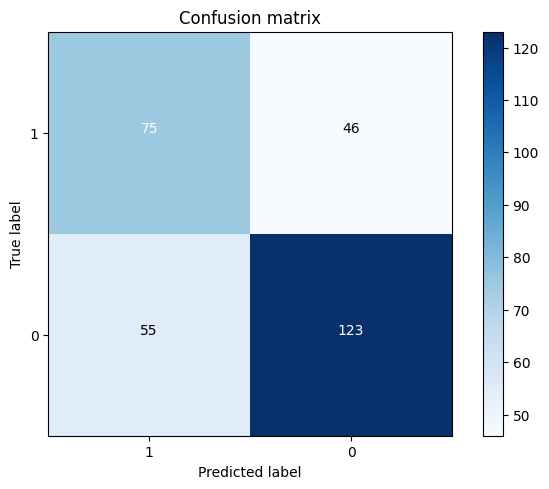

In [8]:
matrix = confusion_matrix(y_train,y_train_predict) #获得混淆矩阵
class_names = ['1', '0' ]
plt.figure()
plot_confusion_matrix(matrix
                      , classes=class_names
                      , title='Confusion matrix')

plt.savefig('./images/线性判别分析算法训练集混淆矩阵.png')
plt.show()

In [9]:
print(classification_report(y_pred= y_train_predict,y_true=y_train))  #训练集上的性能评价

              precision    recall  f1-score   support

         0.0       0.58      0.62      0.60       121
         1.0       0.73      0.69      0.71       178

    accuracy                           0.66       299
   macro avg       0.65      0.66      0.65       299
weighted avg       0.67      0.66      0.66       299



In [10]:
testdata = np.loadtxt("data/horseColicTest.txt")
x_test = testdata[:,:-1]
y_test = testdata[:,-1]
y_predict = lda.predict(x=x_test,w=w,center1=center1,center2=center2)

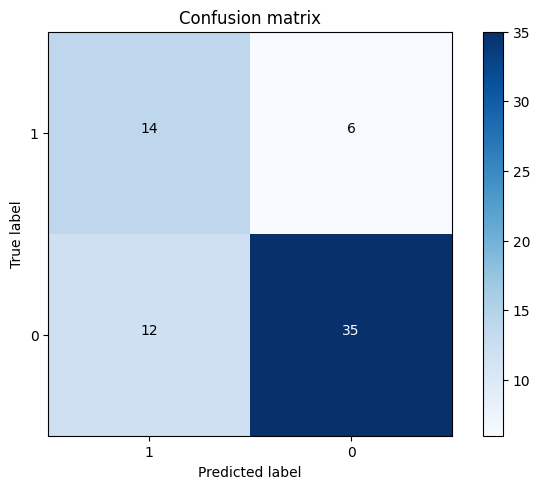

In [11]:
matrix_test = confusion_matrix(y_test,y_predict) #获得混淆矩阵
class_names = ['1', '0' ]
plt.figure()
plot_confusion_matrix(matrix_test
                      , classes=class_names
                      , title='Confusion matrix')

plt.savefig('./images/线性判别分析算法测试集混淆矩阵.png')
plt.show()

In [12]:
print(classification_report(y_pred=y_predict,y_true=y_test)) # 测试集上的性能评价

              precision    recall  f1-score   support

         0.0       0.54      0.70      0.61        20
         1.0       0.85      0.74      0.80        47

    accuracy                           0.73        67
   macro avg       0.70      0.72      0.70        67
weighted avg       0.76      0.73      0.74        67



## 对二分类数据集 heart.csv进行线性判别分析
![demo.jpg](./images/%E6%95%B0%E6%8D%AE%E8%AF%B4%E6%98%8E.jpg)

In [20]:
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('data/heart.csv')
# df_heart.describe()
## 还原定类特征由整数转为实际对应的字符串，还原为真实含义
df['sex'][df['sex']==0] = 'female' ##sex列的数据值为0的为女性
df['sex'][df['sex']==1] ='male' ##sex列数据值为1的为男性
df['cp'][df['cp'] == 0] = 'typical angina'
df['cp'][df['cp'] == 1] = 'atypical angina'
df['cp'][df['cp'] == 2] = 'non-anginal pain'
df['cp'][df['cp'] == 3] = 'asymptomatic'
 
df['fbs'][df['fbs'] == 0] = 'lower than 120mg/ml'
df['fbs'][df['fbs'] == 1] = 'greater than 120mg ml'
 
df['restecg'][df['restecg'] == 0] = 'normal'
df['restecg'][df['restecg'] == 1] = 'ST-T wave abnormality'
df['restecg'][df['restecg'] == 2] = 'left ventricular hyper trophy'
 
df['exang'][df['exang'] == 0] = 'no'
df['exang'][df['exang'] == 1] = 'yes'
 
df['slope'][df['slope'] == 0] = 'upsloping'
df['slope'][df['slope'] == 1] = 'flat'
df['slope'][df['slope'] == 2] = 'downsloping'
 
df['thal'][df['thal'] == 0] = 'unknown'
df['thal'][df['thal'] == 1] = 'normal'
df['thal'][df['thal'] == 2] = 'fixed defect'
df['thal'][df['thal'] == 3] = 'reversable defect'

y_df = pd.DataFrame()
y_df['y'] = df['target']
# ####################将类别变量赋值为真正的字符串值用于catBoost分类###########
# df1 = pd.DataFrame()
# df1 = pd.concat([df,y_df],axis=1)
# df1.drop('target',axis=1,inplace=True)
# df1.to_csv('Heart.csv',index=False)
# ##########################################################################
# 导出预处理后的数据
# 独热编码
df = pd.get_dummies(df)
new_df = pd.DataFrame()
new_df = pd.concat([df,y_df],axis=1)
new_df.drop('target',axis=1,inplace=True)
new_df.head(5)
new_df.to_csv('data/process_heart.csv',index=False)


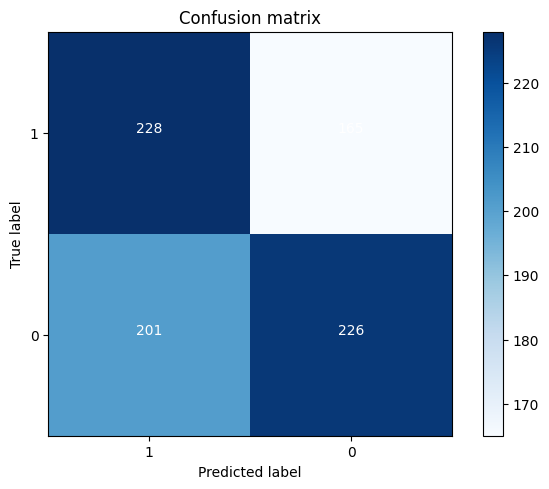

In [23]:
lda2 = myLDA()
heart_data = new_df.values
train_data = heart_data[0:int(0.8*heart_data.shape[0]),:]
testdata = heart_data[int(0.8*heart_data.shape[0])+1:,:]
w,center1,center2=lda2.fit(train_data)
x_train = train_data[:,:-1]
y_train = train_data[:,-1]
y_train_predict = lda2.predict(x=x_train,w = w,center1=center1,center2=center2)
matrix = confusion_matrix(y_train,y_train_predict) #获得混淆矩阵
class_names = ['1', '0' ]
plt.figure()
plot_confusion_matrix(matrix
                      , classes=class_names
                      , title='Confusion matrix')

plt.savefig('./images/LDA心脏病数据集训练集混淆矩阵.png')
plt.show()